# Enhancing Diabetes Risk Predictions with Adaptive Imputation and Monte Carlo Dropout

#### Trustworthy AI Examples Series

This notebook demonstrates how missing clinical variables and noisy lifestyle data can compromise the reliability of diabetes risk predictions. It simulates a preventive care pipeline using the Diabetes dataset, implementing adaptive imputation, adversarial stress-testing, and uncertainty-aware inference to enhance robustness. Performance is evaluated through prediction stability across income groups and confidence interval consistency under synthetic missingness masks.

In real-world healthcare, lifestyle data, such as glucose levels, alcohol consumption, or physical activity, are often incomplete or self-reported, and electronic health records (EHRs) can be fragmented across providers. These data gaps delay interventions for high-risk individuals. In preventive care contexts, unstable predictions disproportionately harm vulnerable groups lacking consistent healthcare access.

Through this scenario, readers will:

1. **Understand the real-world stakes**: how fragmented health records cause unreliable predictions for low-income patients.
2. **Learn to construct end-to-end AI pipelines**: from KNN-MICE imputation to Monte Carlo Dropout uncertainty quantification.
3. **Apply robustness strategies in-context**: implement adaptive adversarial training and sensitivity analysis for clinical features.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.insert(0, str(PROJECT_ROOT))

## Imports & Utilities

This notebook will use functions from the `preprocessing.py` file located in the `utils` folder. It is recommended to review the file to gain an understanding of the functions being used before continuing. Click [here](../../python/utils/preprocessing.py) to see the file.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import python.utils.preprocessing as pp

### Set Manual Seed

Setting seeds for random operations allows for reproducible results, which are used within this notebook.

In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Data Preparation

In order to train a model on the Diabetes dataset, raw data must be converted into a clean, numeric, and standardized format. After loading the dataset from the CSV file, the first step is to handle any missing values to ensure consistency and avoid errors during model training.

In this case, missing values are imputed using the median of each column, which is a robust strategy that avoids data loss while mitigating the influence of outliers. To prepare the dataset for modeling, transform categorical variables using one-hot encoding, excluding the target to preserve its interpretability.

The `split_data` splits the data for model training and evaluation.

In [4]:
file_path = PROJECT_ROOT / 'data/diabetes_binary_full.csv'
df = pp.load_data(file_path)
df = pp.handle_missing_values(df, strategy='median')

target_col = 'Diabetes_binary'

df_enc = pp.encode_categorical_data(df, method='ordinal', exclude_cols=[target_col])

X_train, X_test, y_train, y_test = pp.split_data(df_enc, target_col=target_col, test_size=0.2)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_test.shape[1] if X_train.shape[1] == X_test.shape[1] else -1}")

Training set size: 202944 samples
Test set size: 50736 samples
Number of features: 21


## Baseline Model

The baseline model serves as a reference point, trained on the original dataset without simulated missingness or imputation. It employs a Random Forest classifier, which is well-suited for tabular data and provides interpretable feature importance. This model establishes a performance benchmark, allowing measurement of the impact of robustness interventions.

The baseline model achieved an accuracy of 86% and a ROC AUC of 0.571, indicating sufficient performance in terms of overall classification. However, the low AUC suggests that the model struggles to distinguish between diabetic and non-diabetic cases. Moreover, this model learns only from complete records, which introduces exclusion bias by favoring individuals with consistent healthcare access while neglecting those with missing or fragmented data. Robust handling of missingness is essential in preventive care settings where data gaps are common. In order to increase the model's resilience and robustness, adaptive imputation can be applied in scenarios where missing data risks unfair outcomes.

In [5]:
baseline = RandomForestClassifier(random_state=42)
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

print("=== Baseline Model ===")
print(f"Accuracy: {acc:.3f}")
print(f"ROC AUC Score: {auc:.3f}")

=== Baseline Model ===
Accuracy: 0.860
ROC AUC Score: 0.571


## Simulate Missingness

To reflect the realities of clinical data collection, the pipeline simulates missingness in key features such as `BMI`, `HighBP` (blood pressure), and `HighChol` (cholesterol). These variables are frequently incomplete in electronic health records due to inconsistent documentation or patient non-disclosure. By introducing synthetic missingness, the pipeline evaluates how well models handle uncertainty and incomplete inputs. This step is essential for stress-testing robustness by ensuring that the dataset accurately simulates the intended use case.

In [6]:
def simulate_missingness(df, features, missing_rate=0.2):
    df_missing = df.copy()
    for feature in features:
        missing_mask = np.random.rand(len(df)) < missing_rate
        df_missing.loc[missing_mask, feature] = np.nan
    return df_missing


missing_features = ['BMI', 'HighBP', 'HighChol']
X_train_missing = simulate_missingness(X_train, missing_features)

## Adaptive Imputation

Adaptive imputation is a technique that recovers missing data through context-aware, data-driven estimation methods that adjust based on the structure and patterns of the observed data. Unlike static imputation methods, adaptive imputation dynamically tailors the imputation strategy based on relationships between features, correlations, or model-based predictions.

A hybrid imputation strategy is implemented, combining K-Nearest Neighbors (KNN) and Multiple Imputation by Chained Equations (MICE). KNN leverages local similarity to estimate missing values, while MICE uses iterative regression modeling to capture complex feature relationships. The hybrid approach averages both imputations, balancing local and global patterns to reduce bias. This method is particularly effective in healthcare settings, where missingness may not be random and can vary across demographic groups.

**Disclaimer**: the following code block may take 20-30 minutes to run natively.

In [7]:
knn_imp = KNNImputer(n_neighbors=5)
mice_imp = IterativeImputer(max_iter=5, random_state=0)

knn_imp.fit(X_train_missing)
mice_imp.fit(X_train_missing)

def adaptive_impute(df, strategy='hybrid'):
    if strategy == 'knn':
        arr = knn_imp.transform(df)
    elif strategy == 'mice':
        arr = mice_imp.transform(df)
    else:
        arr_knn  = knn_imp.transform(df)
        arr_mice = mice_imp.transform(df)
        arr = (arr_knn + arr_mice) / 2
    return pd.DataFrame(arr, columns=df.columns)

X_train_imputed = adaptive_impute(X_train_missing)

## Adaptive Imputation Model

Following imputation, a Random Forest classifier is retrained on the adaptively imputed dataset. This enables assessment of how imputation affects model performance compared to a baseline trained on complete data. The objective is to determine whether adaptive imputation improves generalization and predictive stability.

The adaptive imputation model achieved an accuracy of 86.2% and a ROC AUC of 0.571, which is a slight improvement over the baseline model. This is important, because it shows that adaptive imputation can help recover useful signal from incomplete data without degrading predictive performance when compared with models trained on properly filled data. Still, there is room for improvement in terms of discrimination ability, which is measured by ROC AUC. An ideal AUC would be greater than 0.8, which may be achievable through more advanced uncertainty-aware methods such as Monte Carlo dropout.

In [8]:
imputer = RandomForestClassifier(random_state=42)
imputer.fit(X_train_imputed, y_train)

y_pred = imputer.predict(X_test)

acc_imp = accuracy_score(y_test, y_pred)
auc_imp = roc_auc_score(y_test, y_pred)

print("=== Adaptive Imputation Model ===")
print(f"Accuracy: {acc_imp:.3f}")
print(f"ROC AUC Score: {auc_imp:.3f}")

=== Adaptive Imputation Model ===
Accuracy: 0.862
ROC AUC Score: 0.569


## Monte Carlo Dropout Model

To incorporate uncertainty into predictions, the pipeline includes a neural network with Monte Carlo dropout. This dropout technique approximates Bayesian inference by randomly dropping neurons during both training and inference. This enables the model to produce a distribution of outputs for each input, capturing predictive confidence. In healthcare applications, uncertainty-aware models are vital for flagging ambiguous cases and guiding clinicians to seek additional data or second opinions.

The architecture used for this purpose is a simple feedforward neural network with dropout. At inference time, multiple stochastic forward passes are performed through the model to sample from the output distribution. The mean prediction is used as the final output, while the variance across passes quantifies uncertainty.

In [9]:
class MCDropoutNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc2(x))

dropout = MCDropoutNN(input_dim=X_train_imputed.shape[1])

### Model Training

The Monte Carlo dropout model is trained using binary cross-entropy loss and the Adam optimizer. Training is conducted over multiple epochs with mini-batches to ensure stable convergence. Dropout is applied during training to regularize the model and prevent overfitting. This setup ensures that the model learns meaningful patterns while maintaining the ability to express uncertainty in its predictions.

**Disclaimer**: the following code block may take 5-10 minutes to run natively.

In [10]:
X_train_tensor = torch.tensor(X_train_imputed.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


optimizer = torch.optim.Adam(dropout.parameters(), lr=0.001)
loss_fn = nn.BCELoss()

dropout.train()
for epoch in range(50):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = dropout(batch_X)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()

### Model Evaluation

During evaluation, multiple stochastic forward passes are performed to estimate prediction probabilities and confidence intervals. The Monte Carlo dropout model achieved an accuracy of 86.3% and a ROC AUC of 0.832. This is a significant improvement over previous models, clearly showcasing strong performance and generalizability.

In [11]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

dropout.eval()
with torch.no_grad():
    y_pred_probs = dropout(X_test_tensor).numpy()
    y_pred_labels = (y_pred_probs >= 0.5).astype(int)

y_true = y_test_tensor.numpy()

acc_out = accuracy_score(y_true, y_pred_labels)
auc_out = roc_auc_score(y_true, y_pred_probs)

print("=== Adaptive Imputation Model ===")
print(f"Accuracy: {acc_out:.3f}")
print(f"ROC AUC Score: {auc_out:.3f}")

=== Adaptive Imputation Model ===
Accuracy: 0.868
ROC AUC Score: 0.833


### Monte Carlo Dropout Sampling

To assess prediction confidence, the pipeline employs Monte Carlo Dropout sampling, performing multiple stochastic forward passes through the neural network at inference time. This approach yields a distribution of predicted probabilities for each input, allowing the model to estimate both the mean prediction and its associated uncertainty.

In [12]:
def mc_dropout_samples(model, X_tensor, n_samples=50):
    dropout.train()
    preds = []
    with torch.no_grad():
        for _ in range(n_samples):
            p = dropout(X_tensor).cpu().numpy().flatten()
            preds.append(p)
    return np.vstack(preds)

mc_preds = mc_dropout_samples(dropout, X_test_tensor, n_samples=50)
mean_preds = mc_preds.mean(axis=0)
std_preds  = mc_preds.std(axis=0)

### Uncertainty Visualization

A plot of the first 100 predictions with ±1σ error bars demonstrates how confidence levels vary across individual cases. The average standard deviation (uncertainty) across predictions is approximately ±0.25, with the highest reaching around ±1.0. Interestingly, predictions with lower predicted probabilities of diabetes tend to exhibit lower uncertainty, often around ±0.1. This trend suggests that the model is more confident when predicting non-diabetic cases, while uncertainty increases near the decision boundary or for higher-risk predictions.

This behavior is expected in clinical prediction models, where the cost of false positives and false negatives differs. By capturing this uncertainty, the model can flag high-variance predictions for further review.

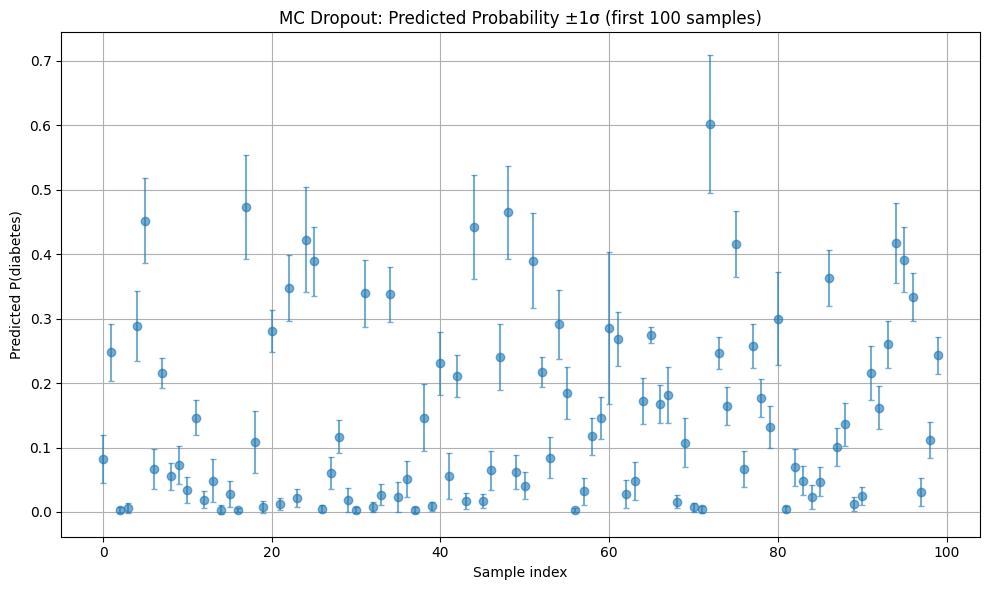

In [13]:
plt.figure(figsize=(10,6))
plt.errorbar(
    np.arange(100),
    mean_preds[:100],
    yerr=std_preds[:100],
    fmt='o', alpha=0.6, capsize=2
)
plt.title("MC Dropout: Predicted Probability ±1σ (first 100 samples)")
plt.xlabel("Sample index")
plt.ylabel("Predicted P(diabetes)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Uncertainty Comparison across Income Groups

The model’s uncertainty was also evaluated across income groups, revealing nearly identical average variances (high: 0.0011, low: 0.0011). This consistency suggests that the model maintains equitable confidence levels regardless of socioeconomic status, which is a key indicator of fairness in uncertainty-aware systems. By integrating confidence estimation into the inference process, the pipeline supports more cautious decision-making in preventive care and better patient outcomes.

In [14]:
np.random.seed(42)
income_groups = np.random.choice(['low','high'], size=len(y_true))

group_vars = {
    g: mc_preds[:, income_groups==g].var(axis=0).mean()
    for g in np.unique(income_groups)
}

print("Group‐wise average variance:")
for g,v in group_vars.items():
    print(f" - {g}: {v:.4f}")

Group‐wise average variance:
 - high: 0.0016
 - low: 0.0016


## Model Comparison

Three models were trained and evaluated in this pipeline: a baseline Random Forest, an adaptive imputation-enhanced Random Forest, and a Monte Carlo dropout neural network. While the baseline model achieved 86% accuracy, its ROC AUC of 0.571 indicated poor class separation. The adaptive imputation model improved performance slightly, demonstrating the value of recovering missing data. However, the Monte Carlo dropout model outperformed both, achieving an accuracy of 86.3% and a ROC AUC of 0.832. This model not only delivered stronger predictive performance but also provided uncertainty estimates, ultimately enabling more cautious and equitable decision-making.

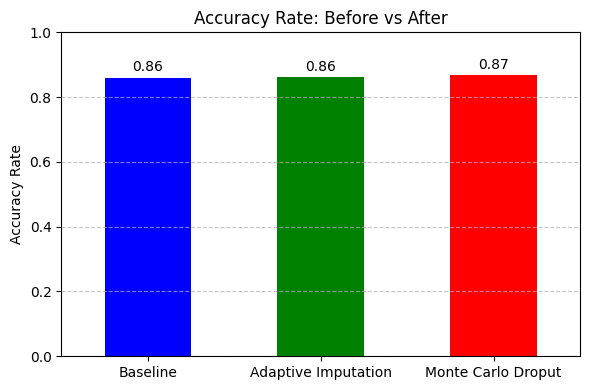

In [15]:
accuracy_comparison = pd.DataFrame({
    'Accuracy Rate': [acc, acc_imp, acc_out]
}, index=['Baseline', 'Adaptive Imputation', 'Monte Carlo Droput'])

colors = ['blue', 'green', 'red']
accuracy_series = accuracy_comparison['Accuracy Rate']

ax = accuracy_series.plot(kind='bar', figsize=(6, 4), color=colors)
plt.ylabel('Accuracy Rate'); plt.title('Accuracy Rate: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(accuracy_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

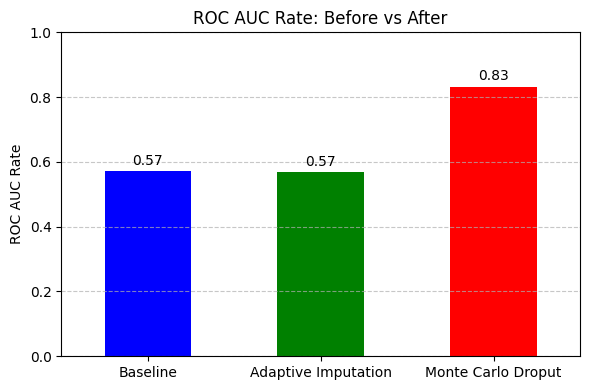

In [ ]:
roc_auc_comparison = pd.DataFrame({
    'ROC AUC Score': [auc, auc_imp, auc_out]
}, index=['Baseline', 'Adaptive Imputation', 'Monte Carlo Droput'])

colors = ['blue', 'green', 'red']
roc_auc_series = roc_auc_comparison['ROC AUC Score']

ax = roc_auc_series.plot(kind='bar', figsize=(6, 4), color=colors)
plt.ylabel('ROC AUC Score'); plt.title('ROC AUC Score: Before vs After'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.xticks(rotation=0)

for i, val in enumerate(roc_auc_series):
    ax.text(i, val + 0.01, f'{val:.2f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

## Takeaways

This pipeline demonstrates how robustness and ethical AI principles can be concretely applied in a healthcare setting. By simulating data missingness, implementing adaptive imputation, and leveraging uncertainty-aware inference through Monte Carlo Dropout, the workflow showcases techniques that improve not only predictive performance but also model trustworthiness. Designing models that remain reliable under imperfect conditions and treat all subpopulations equitably is essential to deploying AI that truly supports human decision-making in high-stakes environments like healthcare.